In [1]:
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/dari-pasentran-ke-istana.gz
# !tar -xf dari-pasentran-ke-istana.gz

In [2]:
import librosa
import pyworld as pw
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

In [3]:
# !pip3 install malaya-gpu -U --no-deps

In [4]:
import yaml

with open('config.yaml') as fopen:
    config = yaml.load(fopen)
    
config

/home/husein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


{'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 20,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

In [5]:
import numpy as np

# https://github.com/TensorSpeech/TensorFlowTTS/blob/master/tensorflow_tts/utils/outliers.py
def is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return x <= lower or x >= upper


def remove_outlier(x, p_bottom: int = 25, p_top: int = 75):
    """Remove outlier from x."""
    p_bottom = np.percentile(x, p_bottom)
    p_top = np.percentile(x, p_top)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if is_outlier(value, p_bottom, p_top):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0
    x[indices_of_outliers] = np.max(x)
    return x

In [6]:
import re

_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [7]:
def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

In [8]:
from unidecode import unidecode
import malaya

normalizer = malaya.normalize.normalizer(date = False, time = False)

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    string = string.replace('&', ' dan ')
    string = re.sub(r'[ ]+', ' ', string).strip()
    if string[-1] in ['-', ',']:
        string = string[:-1]
    if string[-1] != '.':
        string = string + '.'
    
    if normalize:
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True,
                                      normalize_year = True)
        string = string['normalize']
    else:
        string = string
    string = put_spacing_num(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = string.lower()
    return string, tts_encode(string, add_eos = add_eos)

In [9]:
# cleaning('Pada tahun 1960-an, dan awal 1970-an, regim cenderung mengabaikan anjing.')

In [10]:
# from glob import glob
# from tqdm import tqdm

# txts = glob('../youtube/malay/*istana/*istana*/*.txt')
# txts.extend(glob('../youtube/malay2/*turki/*turki*/*.txt'))
# txts.extend(glob('../youtube/malay2/*turki-short/*turki*/*.txt'))
# txts.extend(glob('../youtube/malay/*istana-short/*istana*/*.txt'))
# len(txts)

In [11]:
import json
from glob import glob
from tqdm import tqdm

with open('true-case-male.json') as fopen:
    txts = json.load(fopen)
    
len(txts), txts[0]

(38267,
 ['../youtube/malay/dari-pasentran-ke-istana/output-text-dari-pasentran-ke-istana/perubahan-rejim-dan-pergelutan-demi-kelangsungan-12.mp3-26.wav.txt',
  'the Jakarta post menyebut pada 1 September',
  'The Jakarta Post menyebut pada 1 September.'])

In [12]:
# [(no, i) for no, i in enumerate(txts)]

In [13]:
import malaya_speech
from malaya_speech import Pipeline
vad = malaya_speech.vad.webrtc()

def process(txts, silent_trail = 500, maxlen = 25):
    txts = txts[0]
    audios, mels, text_ids, f0s, energies = [], [], [], [], []

    for f in tqdm(txts):
        text = f[2]
        f = f[0]
        if re.match('^.*(RM|rm)[0-9]+.*$', text):
            continue
        text = cleaning(text)
        r = f.replace('output-text', 'output-wav').replace('.txt', '')

        audio, _ = malaya_speech.load(r, sr = config['sampling_rate'])

        if (len(audio) / config['sampling_rate']) > maxlen:
            print('skipped, audio too long')
            continue

        if config['trim_silence']:
            y_= malaya_speech.resample(audio, config['sampling_rate'], 16000)
            y_ = malaya_speech.astype.float_to_int(y_)
            frames = list(malaya_speech.generator.frames(audio, 30, config['sampling_rate']))
            frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
            frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
            grouped_deep = malaya_speech.group.group_frames(frames_webrtc)
            grouped_deep = malaya_speech.group.group_frames_threshold(grouped_deep, 0.1)
            r = []
            for g in grouped_deep:
                if g[1]:
                    g = g[0].array
                else:
                    g = np.concatenate([g[0].array[:silent_trail], g[0].array[-silent_trail:]])
                r.append(g)
            audio = np.concatenate(r)

        D = librosa.stft(
            audio,
            n_fft=config['fft_size'],
            hop_length=config['hop_size'],
            win_length=config['win_length'],
            window=config['window'],
            pad_mode='reflect',
        )
        S, _ = librosa.magphase(D) 
        fmin = 0 if config["fmin"] is None else config["fmin"]
        fmax = sampling_rate // 2 if config["fmax"] is None else config["fmax"]
        mel_basis = librosa.filters.mel(
            sr=config['sampling_rate'],
            n_fft=config["fft_size"],
            n_mels=config["num_mels"],
            fmin=fmin,
            fmax=fmax,
        )
        mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
        audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
        audio = audio[: len(mel) * config['hop_size']]

        _f0, t = pw.dio(
            audio.astype(np.double),
            fs=config['sampling_rate'],
            f0_ceil=fmax,
            frame_period=1000 * config['hop_size'] / config['sampling_rate'],
        )
        f0 = pw.stonemask(audio.astype(np.double), _f0, t, config['sampling_rate'])
        if len(f0) >= len(mel):
            f0 = f0[: len(mel)]
        else:
            f0 = np.pad(f0, (0, len(mel) - len(f0)))

        # extract energy
        energy = np.sqrt(np.sum(S ** 2, axis=0))
        f0 = remove_outlier(f0)
        energy = remove_outlier(energy)

        if config["global_gain_scale"] > 0.0:
            audio *= config["global_gain_scale"]

        if len(energy[energy != 0]) == 0 or len(f0[f0 != 0]) == 0:
            print('skipped')
            continue

        audios.append(audio)
        mels.append(mel)
        text_ids.append(text)
        f0s.append(f0)
        energies.append(energy)
    
    return [[audios, mels, text_ids, f0s, energies]]

In [14]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [15]:
i = 135
r = process((txts[i: i + 10],))[0]

100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


In [16]:
ipd.Audio(r[0][1], rate = 22050)

In [17]:
r[2][1][0]

'dan pada sisi lain , mereka menentang campur aduk pemikiran islam dengan kepercayaan karut tempat dari sisi kedua itu .'

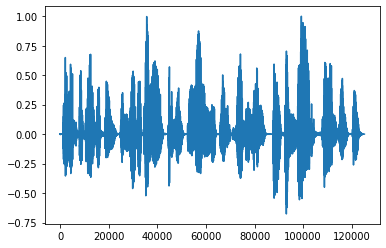

In [18]:
plt.plot(r[0][2])

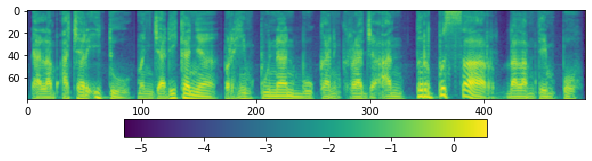

In [19]:
mel_outputs_ = np.reshape(r[1][2], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [20]:
import mp

audios, mels, text_ids, f0s, energies = [], [], [], [], []

In [21]:
for i in range(0, len(txts), 1000):
    index = min(i + 1000, len(txts))
    b = txts[i: index]
    results = mp.multiprocessing(b, process, cores = 10, returned = True)
    for result in results:
        audios.extend(result[0])
        mels.extend(result[1])
        text_ids.extend(result[2])
        f0s.extend(result[3])
        energies.extend(result[4])

 32%|███▏      | 32/100 [00:28<00:58,  1.17it/s]

skipped, audio too long


 80%|████████  | 80/100 [01:09<00:19,  1.02it/s]

skipped, audio too long


 90%|█████████ | 90/100 [01:18<00:12,  1.22s/it]

skipped, audio too long


  5%|▌         | 5/100 [00:05<01:44,  1.10s/it]

skipped, audio too long


 21%|██        | 21/100 [00:20<01:00,  1.32it/s]

skipped, audio too long


 65%|██████▌   | 65/100 [01:06<00:40,  1.15s/it]

skipped, audio too long


 68%|██████▊   | 68/100 [01:08<00:38,  1.21s/it]

skipped, audio too long


 65%|██████▌   | 65/100 [01:18<00:41,  1.19s/it]

skipped, audio too long


 69%|██████▉   | 69/100 [01:25<00:35,  1.13s/it]

skipped, audio too long


 96%|█████████▌| 96/100 [01:44<00:05,  1.47s/it]

skipped, audio too long


 27%|██▋       | 27/100 [00:13<00:34,  2.09it/s]

skipped


 14%|█▍        | 14/100 [00:09<00:58,  1.46it/s]

skipped


 20%|██        | 20/100 [00:11<01:04,  1.23it/s]

skipped


 24%|██▍       | 24/100 [00:08<00:25,  2.96it/s]

skipped


 58%|█████▊    | 58/100 [00:17<00:12,  3.49it/s]

skipped


 21%|██        | 21/100 [00:06<00:21,  3.66it/s]

skipped


 24%|██▍       | 24/100 [00:08<00:23,  3.22it/s]

skipped


 56%|█████▌    | 56/100 [00:17<00:13,  3.27it/s]

skipped


 97%|█████████▋| 97/100 [00:33<00:00,  3.16it/s]

skipped


 89%|████████▉ | 89/100 [00:23<00:02,  4.51it/s]

skipped


 42%|████▏     | 42/100 [00:09<00:17,  3.29it/s]

skipped


 61%|██████    | 61/100 [00:14<00:15,  2.49it/s]

skipped


  3%|▎         | 3/100 [00:00<00:27,  3.48it/s]

skipped


 23%|██▎       | 23/100 [00:04<00:14,  5.30it/s]

skipped


 28%|██▊       | 28/100 [00:07<00:16,  4.44it/s]

skipped


 70%|███████   | 70/100 [00:17<00:06,  4.30it/s]

skipped


 70%|███████   | 70/100 [00:19<00:10,  2.74it/s]

skipped


 34%|███▍      | 34/100 [00:08<00:16,  4.02it/s]

skipped


 31%|███       | 31/100 [00:06<00:13,  5.23it/s]

skipped


 41%|████      | 41/100 [00:09<00:12,  4.76it/s]

skipped


 63%|██████▎   | 63/100 [00:13<00:09,  4.01it/s]

skipped


  9%|▉         | 9/100 [00:02<00:23,  3.80it/s]]

skipped


 33%|███▎      | 33/100 [00:10<00:17,  3.84it/s]

skipped


 42%|████▏     | 42/100 [00:10<00:11,  5.24it/s]

skipped


 81%|████████  | 81/100 [00:18<00:05,  3.61it/s]

skipped


 11%|█         | 11/100 [00:02<00:23,  3.81it/s]

skipped


 94%|█████████▍| 94/100 [00:23<00:02,  2.98it/s]

skipped


  5%|▌         | 5/100 [00:01<00:30,  3.09it/s]

skipped


 10%|█         | 10/100 [00:02<00:18,  4.88it/s]

skipped


 14%|█▍        | 14/100 [00:04<00:27,  3.10it/s]

skipped


 70%|███████   | 70/100 [00:18<00:07,  4.00it/s]

skipped


 58%|█████▊    | 58/100 [00:14<00:10,  3.86it/s]]

skipped


 35%|███▌      | 35/100 [00:09<00:13,  4.66it/s]

skipped


 72%|███████▏  | 72/100 [00:16<00:05,  4.88it/s]

skipped


  1%|          | 1/100 [00:00<00:13,  7.37it/s]

skipped


 13%|█▎        | 13/100 [00:03<00:25,  3.41it/s]

skipped


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


In [22]:
scaler_mel = StandardScaler(copy=False)
scaler_energy = StandardScaler(copy=False)
scaler_f0 = StandardScaler(copy=False)

for mel, f0, energy in zip(mels, f0s, energies):

    scaler_mel.partial_fit(mel)
    scaler_energy.partial_fit(energy[energy != 0].reshape(-1, 1))
    scaler_f0.partial_fit(f0[f0 != 0].reshape(-1, 1))

In [23]:
for i in tqdm(range(len(mels))):
    mels[i] = scaler_mel.transform(mels[i])

100%|██████████| 38217/38217 [00:12<00:00, 2956.85it/s]


In [24]:
directory_stats = 'male-stats-v2'

In [25]:
def save_statistics_to_file(scaler_list, config):
    os.system(f'mkdir {directory_stats}')
    for scaler, name in scaler_list:
        stats = np.stack((scaler.mean_, scaler.scale_))
        np.save(
            os.path.join(f"{directory_stats}/stats{name}.npy"),
            stats.astype(np.float32),
            allow_pickle=False,
        )

In [26]:
scaler_list = [(scaler_mel, ""), (scaler_energy, "_energy"), (scaler_f0, "_f0")]
save_statistics_to_file(scaler_list, config)

In [27]:
directory = 'output-male-v3'

In [28]:
!rm -rf {directory}

In [29]:
os.system(f'mkdir {directory}')
directories = ['audios', 'mels', 'text_ids', 'f0s', 'energies']
for d in directories:
    os.system(f'mkdir {directory}/{d}')

In [30]:
for i in tqdm(range(len(mels))):
    np.save(f'{directory}/audios/{i}.npy', audios[i])
    np.save(f'{directory}/mels/{i}.npy', mels[i])
    np.save(f'{directory}/text_ids/{i}.npy', text_ids[i])
    np.save(f'{directory}/f0s/{i}.npy', f0s[i])
    np.save(f'{directory}/energies/{i}.npy', energies[i])

100%|██████████| 38217/38217 [04:37<00:00, 137.59it/s]
